### FastAI Transfer Learning on Stanford Cars Dataset with 1Cycle Learning Rate Policy

This notebook trains a FastAI transfer learning model on Resnet50 to 90-91% accuracy at image size 320 and batch size 64 in 30 epochs (a little over 2 hours on Google Cloud 8 CPU/P100 GPU machine). Uses the 1Cycle policy (https://arxiv.org/pdf/1803.09820.pdf) as implemented by the fastai library function use_clr_beta().

Requires 16GB GPU RAM. With 224 pixel images, the model will allow 128 batch size and train faster (to about 1 hour and 30 minutes) at the expense of a 1-1.5% accuracy decrease.

Learning rates for bs=64, sz=320: (8e-3, 1e-3)

Learning rates for bs=128, sz=224: (3e-2, 1e-2)

I observed that some high learning rates cause training loss instability near the peak of the 1cycle, however, these have little effect on the final accuracy result because the learning rate still decreases for several epochs. Despite this, the small amount of instability most likely slows down the overall training time. The model appears to train fastest by using the maximum learning rate that does not cause an increase in training loss after an epoch. This may mean that it is possible to implement a "learning rate saturator" in the 1Cycle policy that checks for unstable training loss and stops increasing the learning rate.

In [1]:
import os
import shutil

In [2]:
%%capture
import random
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [3]:
import imageio

This part is taking the data which has already been organized from Sylvain's code:

In [4]:
if os.path.exists('./Adam-experiments'):
    os.chdir('./Adam-experiments')
if os.path.exists('./data/cars'):
    os.chdir('./data/cars/')

In [5]:
!ls

annots.csv  car_ims  car_ims.tgz  cars_annos.mat  models  tmp  train  valid


In [6]:
import scipy.io
annos = scipy.io.loadmat('cars_annos.mat')

After loading the .mat file with annotations, we need to search through it to get the required info:

In [7]:
annos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [12]:
# Rubric: annotations[0] is the matrix of data
# [0][i] is the ith row of the matrix
# [0][i][j] is the (i,j)th element of the matrix
# j = 0 is fname, 1 is bboxx1, 2 is bboxy1, 
# 3 is bboxx2, 4 is bboxy2, 5 is class, 6 is bool(test)
# to get the fname, append [0]
# to get all others, append [0][0]

In [10]:
annotations = np.array(annos['annotations'])

In [11]:
len(annotations[0])

16185

In [13]:
from collections import defaultdict

#classes are minus 1 to convert MATLAB indexing

train_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 0]
train_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 0]

test_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 1]
test_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 1]

train_data = zip(train_classes, train_fnames)
test_data = zip(test_classes, test_fnames)

train_dict = defaultdict(list)
test_dict = defaultdict(list)

for tr_cl, tr_fname in train_data:
    train_dict[tr_cl].append(tr_fname)
    
for ts_cl, ts_fname in test_data:
    test_dict[ts_cl].append(ts_fname)


Now we need to get the actual car names that correspond to each class number:

In [8]:
classes = pd.DataFrame(annos['class_names'])

Function to get the car name from the class number:

In [76]:
def car_name(cl):
    return classes.get(cl).values[0][0]
car_name(0)

'AM General Hummer SUV 2000'

WARNING: Unfortunately fastai mixes the class numbers up in a strange manner, so later on we will need to create a dictionary to convert back and forth between fastai classes and the actual classes. This will only be necessary after we create the fastai model data however, so for now we will use the original class numbers just to verify that they make sense.

['car_ims/012447.jpg', 'car_ims/012448.jpg', 'car_ims/012449.jpg', 'car_ims/012450.jpg']


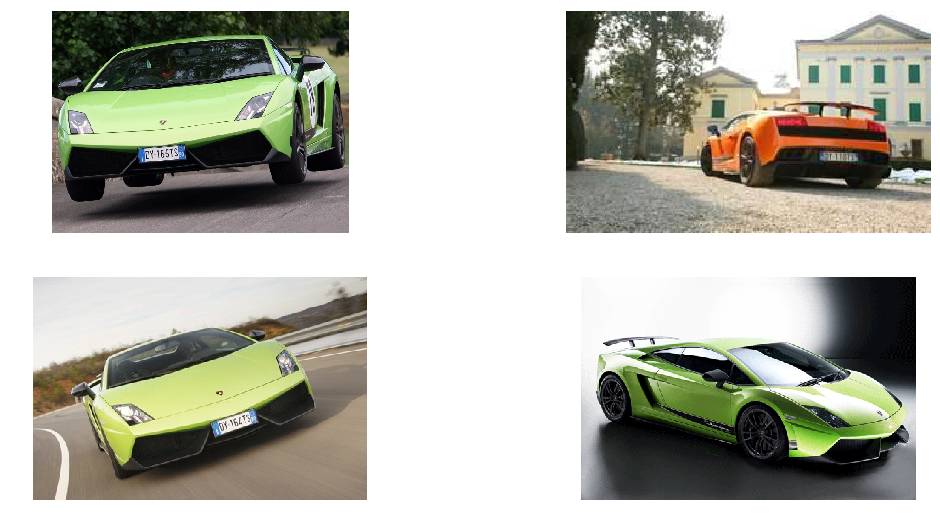

Lamborghini Gallardo LP 570-4 Superleggera 2012


In [81]:
# Look at several images from the training set
rand_cl = rng.choice(196)
print(train_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(train_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show() 

print(car_name(rand_cl))

['car_ims/012483.jpg', 'car_ims/012484.jpg', 'car_ims/012485.jpg', 'car_ims/012486.jpg']


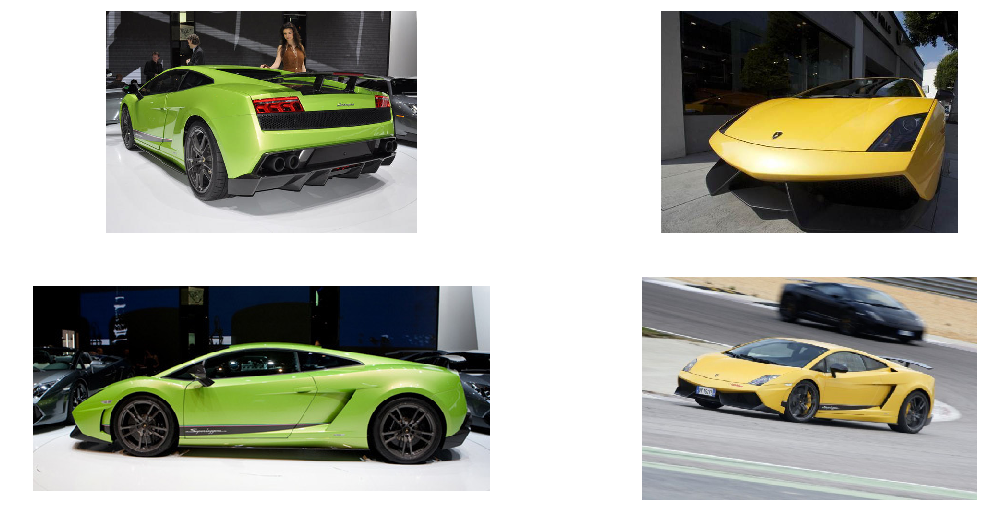

Lamborghini Gallardo LP 570-4 Superleggera 2012


In [82]:
# Look at several images from the testing set
print(test_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(test_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

print(car_name(rand_cl))

In [16]:
# Make train and validation folders for fastai dataloader

if os.path.exists('./train'):
    shutil.rmtree('./train')
if os.path.exists('./valid'):
    shutil.rmtree('./valid')
    
!mkdir ./train
!mkdir ./valid

# Populate the class folders with images
for cl in train_dict.keys():
    train_folder = './train/' + str(cl) + "/"
    valid_folder = './valid/' + str(cl) + "/"
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
    if not os.path.exists(valid_folder):
        os.mkdir(valid_folder)
        
    for tr_img in train_dict[cl]:
        shutil.copy(tr_img, train_folder)
    for val_img in test_dict[cl]:
        shutil.copy(val_img, valid_folder)       

In [17]:
%%capture

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
#import skimage

In [18]:
def get_data(sz, bs=128, arch=resnet50, aug_tfms=transforms_side_on,
             max_zoom=1.05, num_workers=8):
    tfms = tfms_from_model(arch, sz, 
                       aug_tfms=aug_tfms, 
                       max_zoom=max_zoom)
    data = ImageClassifierData.from_paths('', bs=bs, tfms=tfms,
                                          num_workers=num_workers)
    return data

arch = resnet50
sz = 320
# Side on tranforms but increased a bit
aug_tfms = [RandomRotateZoom(deg=20, zoom=1.25, stretch=0.1)]
aug_tfms += [AddPadding(pad=30, mode=cv2.BORDER_CONSTANT)]
aug_tfms += [RandomLighting(0.1, 0.1)]
aug_tfms += [Cutout(n_holes=5, length=14, tfm_y=TfmType.NO)]
aug_tfms += [RandomFlip()]
#aug_tfms += [GoogleNetResize(targ_sz=sz)]

# Note: Extra augmentations provided almost no improvement compared with default tfms
data = get_data(sz, bs=64, aug_tfms=aug_tfms)

In [19]:
# Without precompute set to False, this gives bad results.
learn = ConvLearner.pretrained(arch, data, ps=[0.25,0.25], precompute=False)

Here I modified the default FastAI pipeline by enhancing the augmentations and increasing the dropout on the penultimate layer. Although I haven't extensively tested yet, the augmentations didn't seem to have much effect on overfitting compared to the dropout.

Precomputation seems to just make it much harder to train the entire network afterward, so any time saved on precomputation is not worth it.

In [20]:
learn.opt_fn = optim.Adam

In [21]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [22]:
learn.freeze()

In [23]:
lrf=learn.lr_find(wds = 1e-1, use_wd_sched=True, start_lr=1e-05, end_lr=10)

 82%|████████▏ | 105/128 [02:42<00:35,  1.54s/it, loss=17.2]

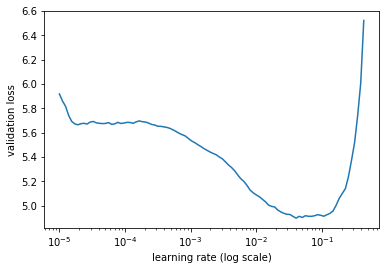

In [24]:
learn.sched.plot(n_skip=0,n_skip_end=4)

This code will barely fit in a 16 GB P100 GPU. So I use empty_cache() in order to maximize the memory utilization.

In addition, running the learning rate finder takes up memory space so when testing a full model it is probably best to run the finders and then run the model all at once separately. 

In [26]:
#Use this frequently to free more GPU memory after each training phase
torch.cuda.empty_cache()

In [27]:
result, ep_vals = learn.fit(8e-3, 1, cycle_len=10, use_clr_beta=(10, 10, 0.9, 0.95), wds=1e-1, use_wd_sched=True, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy                    
    0      3.598358   2.846018   0.289641  
    1      3.068242   2.716087   0.32583                     
    2      3.020826   2.785208   0.30531                     
    3      3.284728   2.951761   0.297973                    
    4      3.408851   3.106022   0.274717                    
    5      3.151623   2.610226   0.344236                    
    6      2.713045   2.279454   0.436637                    
    7      2.304836   1.886151   0.49658                     
    8      1.901478   1.588219   0.578908                    
    9      1.541081   1.500379   0.602537                    


I trained the head only until the training loss was about equal to the validation loss in order to avoid too much overfitting.

In [28]:
learn.unfreeze()
torch.cuda.empty_cache()

 82%|████████▏ | 105/128 [03:07<00:36,  1.61s/it, loss=7.04]

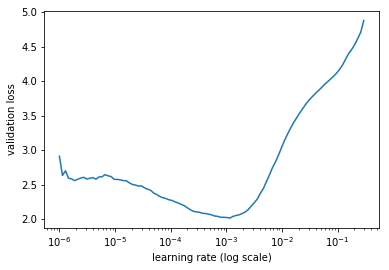

In [29]:
lrf=learn.lr_find(wds = 1e-1, use_wd_sched=True, start_lr=1e-06, end_lr=10)
learn.sched.plot(n_skip=0,n_skip_end=3)

In [30]:
lr2=1e-3

This particular dataset seems to train better with somewhat higher learning rates in the lower layers, possibly because the Imagenet weights don't generalize to this dataset quite as well.

In [31]:
lrs = np.array([lr2/30,lr2/3,lr2])

In [32]:
torch.cuda.empty_cache()

In [33]:
result2, ep_vals2 = learn.fit(lrs, 1, cycle_len=20, use_clr_beta=(10, 10, 0.9, 0.95), wds=1e-1, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                    
    0      1.355165   1.033673   0.718816  
    1      1.047496   1.180662   0.721179                    
    2      0.921035   0.914332   0.745305                    
    3      0.831828   0.914314   0.742445                    
    4      0.807426   0.98389    0.723542                    
    5      0.768815   0.830801   0.757742                    
    6      0.733681   0.856549   0.755254                    
    7      0.72181    0.974191   0.75227                     
    8      1.21875    1.33022    0.624425                    
    9      0.829261   0.667868   0.804502                    
    10     0.594131   0.573926   0.838702                    
    11     0.442421   0.490007   0.859595                    
    12     0.353971   0.534568   0.852382                    
    13     0.308315   0.421435   0.875389                    
    14     0.236438   0.387417   0.885338                    
    15     0.190867   0.36

In [34]:
torch.cuda.empty_cache()

In [35]:
log_preds, y = learn.TTA()

In [36]:
probs = np.exp(log_preds)

In [37]:
avg_TTA = np.mean(probs, axis = 0)

In [38]:
preds = np.argmax(avg_TTA,axis=1)
pred_probs = np.max(avg_TTA,axis=1)
targs = y

In [39]:
TTA_acc = (preds==targs).mean()
print("Final accuracy: " + str(TTA_acc*100)[:5] + "%")

Final accuracy: 91.08%


TTA improved the accuracy very slightly, by about 1%.

Now that the model is finished, we need to create the fastai/regular class number switcher to do further analysis:

In [119]:
# Dictionary to convert from fastai classes to original classes
fai2cl = {}
for i, cl in enumerate(learn.data.classes):
    cl = int(cl)
    fai2cl[i] = cl 

# Dictionary to convert from original classes to fastai classes
cl2fai = {}
for i, cl in enumerate(learn.data.classes):
    cl = int(cl)
    cl2fai[cl] = i

### Worst Performing Classes:
This section plots images of the 10 worst performing classes (classes with the highest error rate).
On the left column is a random wrongly classified image from each of the 10 classes, and on the right is (a random test image from) the incorrect class that the model predicted. 

The worst predicted class is found by taking the mode of the targets that were missed:

In [120]:
missed_imgs = np.where(preds!=targs)[0]
missed_targs = targs[missed_imgs]

In [121]:
from scipy.stats import mode
worst_cl = int(*mode(missed_targs).mode)
print("Class number: " + str(worst_cl))
print(car_name(fai2cl[worst_cl]))

Class number: 164
Chevrolet Express Van 2007


In [122]:
num_missed, bins = np.histogram(missed_targs, bins=np.arange(197))
#bins = bins[:-1].copy()

In [123]:
bottom_ten = np.argsort(num_missed)[-10:]

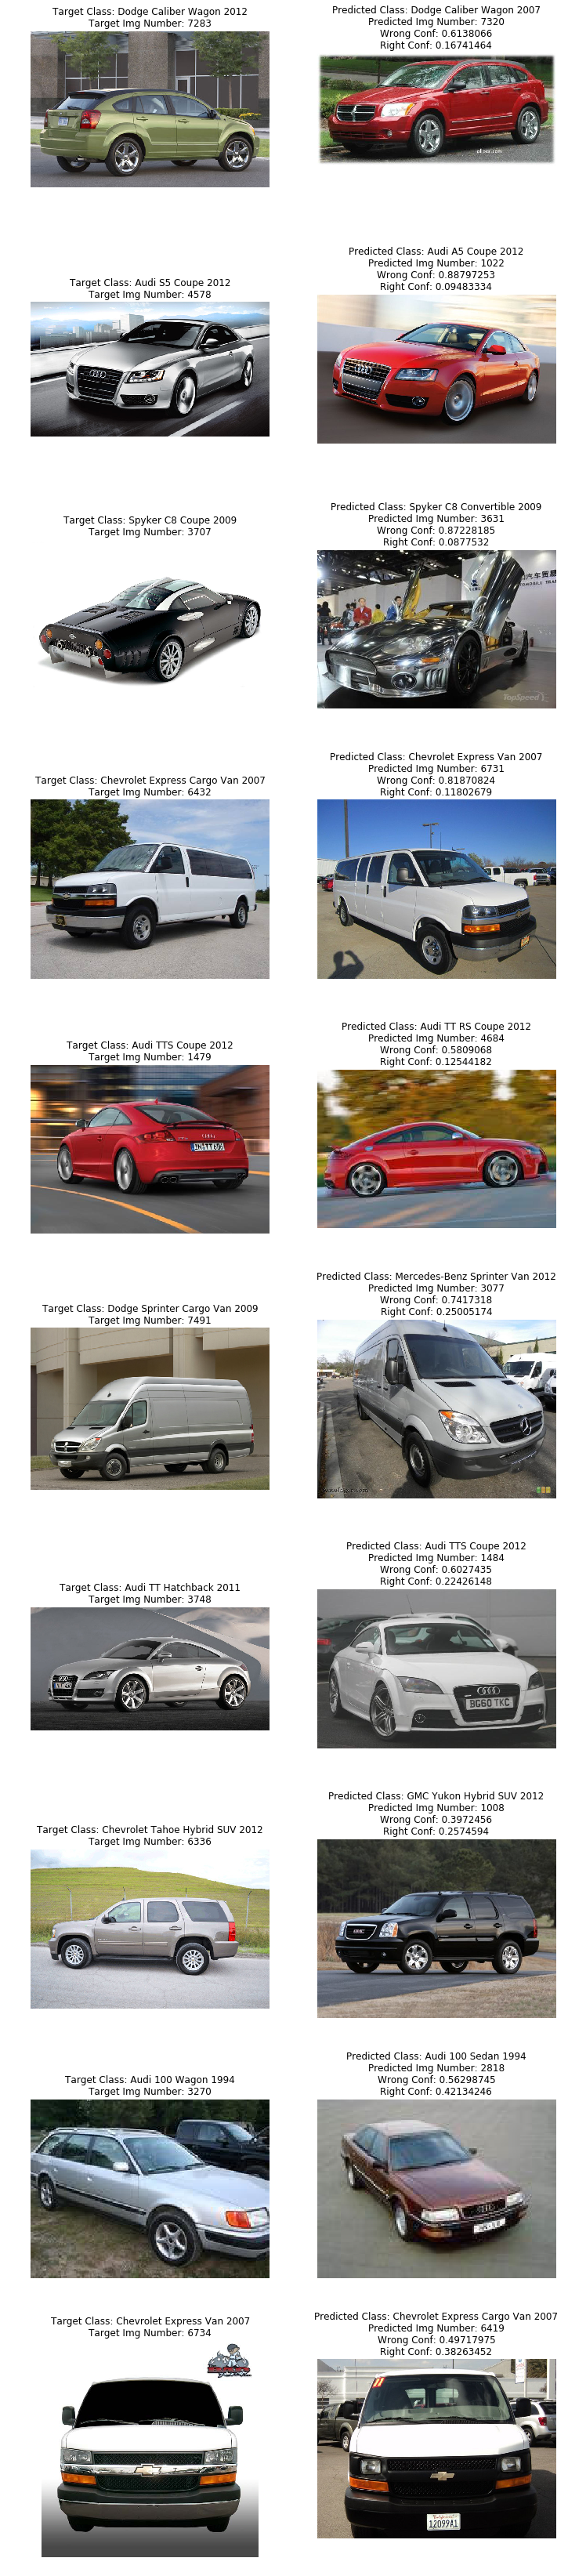

In [125]:
fig = plt.figure(figsize=(12,60))
f = learn.data.val_ds

for i, bot_cl in enumerate(bottom_ten):
    idxs = np.where(missed_targs==bot_cl)[0]
    idx = rng.choice(idxs)
    img_num = missed_imgs[idx]
    targ_fname = f.fnames[img_num]
    targ_car_name = car_name(fai2cl[bot_cl])
    
    # show the image that was misclassfied
    act_img = imageio.imread(targ_fname)
    ax = fig.add_subplot(10, 2, 2*i+1)
    ax.set_title("Target Class: " + targ_car_name +
                "\nTarget Img Number: " + str(img_num))
    plt.imshow(act_img)
    plt.axis('off')
    
    # show a random in the wrongly predicted class for illustration
    pred_cl = preds[img_num]
    pred_nums = np.where(targs==pred_cl)[0]
    pred_num = rng.choice(pred_nums)
    pred_fname = f.fnames[pred_num]
    pred_car_name = car_name(fai2cl[pred_cl])
    
    miss_conf = pred_probs[img_num]
    corr_conf = avg_TTA[img_num][bot_cl]    
    
    pred_img = imageio.imread(pred_fname)
    ax2 = fig.add_subplot(10, 2, 2*i+2)
    ax2.set_title("Predicted Class: " + pred_car_name +
                 "\nPredicted Img Number: " + str(pred_num) +
                 "\nWrong Conf: " + str(miss_conf) +
                 "\nRight Conf: " + str(corr_conf))
    plt.imshow(pred_img)
    plt.axis('off')

plt.show()  

It seems that most of the images that the classifier misses are actually very similar, sometimes even difficult for me as a human to detect. This means that it is probably a good classifier.

Sometimes, the classifier's confidence in the wrong answer is actually somewhat comparable to its confidence in the right answer. In these cases the sum of the wrong and right answer probability is usually close to 1, indicating that the classifier is doing a good job of at least narrowing down the correct class. One thing to note is that a confidence of 0.051 is "random" because there are 196 classes to predict.

Re-running the plot section several times will show more failure examples on the right column (left column is always the correct class).